# Differential genefusion SVs between PCAWG and 1KG

Ideas:

- Use 1kg genefusion evidence to filter PCAWG results.
- Calculate global distribution of fusions
    - Any genefusion greater than median will be discarded
- Calculate local distribution of fusions (per gene)
    - Gene-wise filtering: for each gene, compute the top qth percentile of fusions in the genefusion count distribution. There is sufficient evidence these genefusions are common in the healthy population
    - Or, use median of medians instead of global median
- Population-wise filtering: compute the 95th percentile of normalized count for each gene's genefusion count distribution. Take a distribution of these 95th percentiles. Use the median or 95th percentile imposed on the 95th percentile distribution as filter criteria

## Imports

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import glob
import re
import multiprocessing as mp
from functools import partial
import itertools
import math
os.chdir('/data/jake/genefusion/scripts/python')
#cpus = mp.cpu_count()  // 2
cpus = 64
print(cpus)

36


## Data

genes and locations

In [141]:
gene_file='/data/jake/genefusion/data/gene_file.txt'
df_genes = pd.read_csv(gene_file, sep='\t', header = None)
df_genes.columns = ['chrm', 'start', 'end', 'gene', 'strand']
def gene_location(df_genes, gene):
    gene_row = df_genes[df_genes['gene'] == gene]
    chrm = gene_row['chrm'].values[0]
    start = gene_row['start'].values[0]
    end = gene_row['end'].values[0]
    
    return chrm, start, end
print(gene_location(df_genes, 'OR4F5'))
df_genes.head()
GENES=df_genes['gene'].values.tolist()
GENES = np.unique(GENES).tolist()
len(GENES)

('1', np.int64(69091), np.int64(70008))


26909

In [143]:
# pd.Series(GENES).value_counts().sort_values(ascending=False).head()

- Duplicate gene names exist: 
    - Example: NPIPA7,TM9SF1, etc.
    - from '/data/jake/genefusion/data/gene_file.txt' there is a pattern. The duplicate genes are located on the same chromosome. The difference is that the start and end points vary slightly.
    - Adress this by recording the gene chrm, start, end region
    

In [135]:
# def add_suffix_to_duplicates(strings):
#     count = {}
#     result = []
#     for s in strings:
#         if s in count:
#             count[s] += 1
#             result.append(f"{s}_{count[s]}")
#         else:
#             count[s] = 0
#             result.append(s)
#     return result
# GENES = add_suffix_to_duplicates(GENES)
# [x for x in GENES if '_' in x][:2]

In [144]:
df_genes['gene_loc'] = df_genes.apply(
    lambda row: f'{row["gene"]}_{row["chrm"]}_{row["start"]}_{row["end"]}', 
    axis=1
)
print(df_genes['gene'].unique().shape,df_genes['gene_loc'].unique().shape)
df_genes.head()

(26909,) (26998,)


,chrm,start,end,gene,strand,gene_loc
0,1,69091,70008,OR4F5,pos,OR4F5_1_69091_70008
1,1,134901,139379,AL627309.1,neg,AL627309.1_1_134901_139379
2,1,139790,140339,RP11neg34P13.14,neg,RP11neg34P13.14_1_139790_140339
3,1,367640,368634,OR4F29,pos,OR4F29_1_367640_368634
4,1,621059,622053,OR4F16,neg,OR4F16_1_621059_622053


In [93]:
# GENES_W_LOC = df_genes['gene_loc'].values.tolist()
# GENES_W_LOC.sort()
# GENES_W_LOC[:5]

['7SK_8_144624280_144624570',
 'A1BG_19_58856544_58864865',
 'A1BGnegAS1_19_58859117_58866549',
 'A1CF_10_52559169_52645435',
 'A2ML1_12_8975068_9039597']

## 1kg

In [6]:
#dir_pcawg = '/data/jake/genefusion/data/2024_10_31-fusions'
dir_1kg = '/data/jake/genefusion/data/2024_11_01-fusions-1kg'
dir_1kg_fusions = os.path.join(dir_1kg, 'fusions')

In [7]:
os.listdir(dir_1kg_fusions)[0:5]

['1.neg.ZNF669.247263264.247267674.fusions',
 '17.neg.CCL3.34415602.34417515.fusions',
 '20.pos.VAPB.56964178.57026157.fusions',
 '10.pos.RP11neg162G10.5.38146668.38148038.fusions',
 '11.neg.RP5neg901A4.1.67792277.67797928.fusions']

In [87]:
fusionfiles = glob.glob(os.path.join(dir_1kg_fusions, '*.fusions'))
print(len(fusionfiles))
# filter out empty files
#fusionfiles = [f for f in fusionfiles if os.stat(f).st_size > 0]
print(len(fusionfiles))

26998
26998


## ERG (chrm 21 neg)

In [97]:
regex = re.compile('21\\.neg\\.ERG')
regex
for file in os.listdir(dir_1kg_fusions):
    if regex.search(file):
        ergfile = file
try: 
    ergfile
except NameError:
    print('No ERG file found')

In [98]:
df_erg = pd.read_csv(os.path.join(dir_1kg_fusions, ergfile), sep='\t',header=None)
df_erg.columns = ['chrm', 'start', 'end', 'gene', 'strand']
df_erg.head()

,chrm,start,end,gene,strand
0,21,39756323,39756358,ERG,neg
1,21,39756691,39756781,ERG,neg
2,21,39760265,39760366,ERG,neg
3,21,39755190,39755292,ERG,neg
4,21,39753426,39753527,ERG,neg


### Mode

In [10]:
# including self
print(df_erg['gene'].mode())
print(df_erg['gene'].value_counts().max())
# self value
# non-self
print(df_erg['gene'][df_erg['gene'] != 'ERG'].mode())
# mode value
df_erg['gene'][df_erg['gene'] != 'ERG'].value_counts().max()

0    ERG
Name: gene, dtype: object
9813
0    DMD
Name: gene, dtype: object


np.int64(111)

### Count ranks and distributions

In [294]:
counts = df_erg['gene'][df_erg['gene'] != 'ERG'].value_counts().sort_values(ascending=False)
qs = np.quantile(counts, [0.25, 0.5, 0.75, 0.95])
print(qs)
counts.head()

[ 1.   3.   7.  21.5]


gene
DMD         111
TM4SF2       99
LARGE        78
IL1RAPL1     73
DSCAM        61
Name: count, dtype: int64

In [ ]:
count

[0.         0.47712125 0.84509804 1.35111   ]


[]

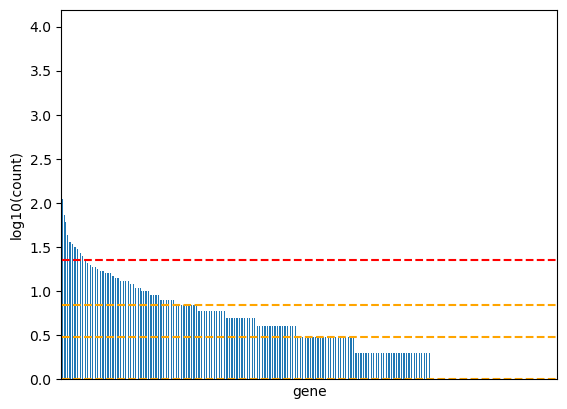

In [293]:
counts = df_erg['gene'].value_counts().apply(lambda x: np.log10(x))
qs = np.quantile(counts, [0.25, 0.5, 0.75, 0.95])
print(qs)
ax = counts.plot(kind='bar', )
ax.hlines(y=qs[0:3], xmin=0, xmax=counts.shape[0], color='orange', linestyle='--')
ax.hlines(y=qs[3], xmin=0, xmax=counts.shape[0], color='red', linestyle='--')

ax.set_ylabel('log10(count)')
ax.set_xticks([])  
ax.set_xticklabels([]) 

#### >= 95th% counts

In [154]:
counts = df_erg['gene'][df_erg['gene'] != 'ERG'].value_counts().sort_values(ascending=False)
qs = np.quantile(counts, [0.25, 0.5, 0.75, 0.95])
counts_95 = counts[counts > qs[3]]
counts_95

gene
DMD          111
TM4SF2        99
LARGE         78
IL1RAPL1      73
DSCAM         61
MTnegND5      53
TTC28         47
SYN3          44
MTnegND4      44
MTnegRNR2     42
DHRSX         36
MTnegCO1      36
NLGN4X        36
FRMPD4        35
MTnegCYB      34
ARHGAP6       34
RBFOX2        33
MTnegCO3      32
PCDH11Y       32
MTnegRNR1     31
FAM19A5       30
CECR2         30
MKL1          30
TBC1D22A      30
TNRC6B        29
EFCAB6        27
NHS           25
MTnegND6      25
PACSIN2       25
REPS2         25
MTnegATP6     24
MTnegND1      24
MTnegND2      23
KIAA1671      23
MID1          22
Name: count, dtype: int64

This is the set we'd like to subtract from PCAWG population

### Mobility tendency

#### 95th percentile

In [63]:
counts_95.index.tolist()[0:5]

['DMD', 'TM4SF2', 'LARGE', 'IL1RAPL1', 'DSCAM']

In [81]:
locations_95 = {}
for gene in counts_95.index:
    locations_95[gene] = gene_location(df_genes, gene)
locations_95 = pd.DataFrame.from_dict(locations_95, orient='index', columns=['chrm', 'start', 'end'])
locations_95.chrm.value_counts()

chrm
22    12
MT    11
X     10
21     1
Y      1
Name: count, dtype: int64

## Population stats

Normalize counts to [0,1] frequencies for comparison across populations

In [151]:
def get_95(fusionfile, normalize=False):
    base = os.path.basename(fusionfile)
    gene = base.split('.')[2]
    df = pd.read_csv(fusionfile, sep='\t', header=None)
    df.columns = ['chrm', 'start', 'end', 'gene', 'strand']
    counts = df['gene'][df['gene'] != gene].value_counts(normalize=normalize)\
        .sort_values(ascending=False)
    q = float(np.quantile(counts, 0.95))
    return q
print(get_95(os.path.join(dir_1kg_fusions, '21.neg.ERG.39751949.40033704.fusions')))
print(get_95(os.path.join(dir_1kg_fusions, '21.neg.ERG.39751949.40033704.fusions'), normalize=True))

21.5
0.004821708903341556


In [125]:
%%capture
with mp.Pool(processes=cpus) as pool:
    dist_95 = pool.map(get_95, fusionfiles)
dist_95[0:5]

In [129]:
filt_95 = [x for x in dist_95 if x is not None]
filt_95[0:5]

[2.0, 4.3999999999999915, 8.5, 1.0, 2.0]

In [130]:
pd.Series(filt_95).describe()

count    25924.000000
mean         7.174452
std         22.957931
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max       2563.600000
dtype: float64

In [131]:
pd.Series(filt_95).quantile(0.95)

np.float64(22.0)

- Median of 95th percentile distribution is 4

- 95th of 95th percentile distribution is 22

### Normalized counts

In [134]:
%%capture
normalize = True
with mp.Pool(processes=cpus) as pool:
    get_95_norm = partial(get_95, normalize=normalize)
    dist_95_norm = pool.map(get_95_norm,fusionfiles)
dist_95_norm[0:5]

In [135]:
filt_95_norm = [x for x in dist_95_norm if x is not None]
filt_95_norm[0:5]

[0.0008090614886731392,
 0.030344827586206838,
 0.005286069651741294,
 0.004424778761061947,
 0.0014124293785310734]

In [137]:
pd.Series(filt_95_norm).describe()

count    25924.000000
mean         0.008536
std          0.044347
min          0.000067
25%          0.000509
50%          0.001144
75%          0.003602
max          1.000000
dtype: float64

In [138]:
pd.Series(filt_95_norm).quantile(0.95)

np.float64(0.019417475728155338)

Use the preceeding results as a gene-wise filter for PCAWG.

Example

If a genefusion has a relative frequency of >20% (95th%tile) within its count distribution in the 1000 genomes population, then ignore it in PCAWG population.

#### Gene-wise filtering

In [169]:
def healthy_fusions(fusionfile, q = 0.95, normalize=True):
    base = os.path.basename(fusionfile)
    gene = base.split('.')[2]
    df = pd.read_csv(fusionfile, sep='\t', header=None)
    df.columns = ['chrm', 'start', 'end', 'gene', 'strand']
    counts = df['gene'][df['gene'] != gene].value_counts(normalize=normalize).sort_values(ascending=False)
    qp = float(np.quantile(counts, q))
    h_fusions = counts[counts > qp].index.tolist()
    h_fusions = [f'{gene}+{x}' for x in h_fusions]
    return h_fusions
healthy_fusions('/data/jake/genefusion/data/2024_11_01-fusions-1kg/fusions/21.neg.ERG.39751949.40033704.fusions')   

['ERG+DMD',
 'ERG+TM4SF2',
 'ERG+LARGE',
 'ERG+IL1RAPL1',
 'ERG+DSCAM',
 'ERG+MTnegND5',
 'ERG+TTC28',
 'ERG+SYN3',
 'ERG+MTnegND4',
 'ERG+MTnegRNR2',
 'ERG+DHRSX',
 'ERG+MTnegCO1',
 'ERG+NLGN4X',
 'ERG+FRMPD4',
 'ERG+MTnegCYB',
 'ERG+ARHGAP6',
 'ERG+RBFOX2',
 'ERG+MTnegCO3',
 'ERG+PCDH11Y',
 'ERG+MTnegRNR1',
 'ERG+FAM19A5',
 'ERG+CECR2',
 'ERG+MKL1',
 'ERG+TBC1D22A',
 'ERG+TNRC6B',
 'ERG+EFCAB6',
 'ERG+NHS',
 'ERG+MTnegND6',
 'ERG+PACSIN2',
 'ERG+REPS2',
 'ERG+MTnegATP6',
 'ERG+MTnegND1',
 'ERG+MTnegND2',
 'ERG+KIAA1671',
 'ERG+MID1']

In [170]:
%%capture
with mp.Pool(processes=cpus) as pool:
    h_fusions = pool.map(healthy_fusions, fusionfiles)

In [171]:
len(list(itertools.chain.from_iterable(h_fusions)))

3786645

In [174]:
%%capture
with mp.Pool(processes=cpus) as pool:
    partial_healthy_fusions = partial(healthy_fusions, q=0.5, normalize=True)
    h_fusions_med = pool.map(partial_healthy_fusions, fusionfiles)

In [175]:
len(list(itertools.chain.from_iterable(h_fusions_med)))

34375533

Median filtering

- Compute genefusion median per gene
- Take median of medians
- Filter any genefusion above median count

In [191]:
def gene_wise_median(fusionfile):
    base = os.path.basename(fusionfile)
    gene = base.split('.')[2]
    df = pd.read_csv(fusionfile, sep='\t', header=None, usecols=[3])
    df.columns = ['gene']
    median = int(df['gene'].value_counts().median())
    return median
gene_wise_median('/data/jake/genefusion/data/2024_11_01-fusions-1kg/fusions/21.neg.ERG.39751949.40033704.fusions')   

3

In [195]:
with mp.Pool(processes=cpus) as pool:
    medians = pool.map(gene_wise_median, fusionfiles)

In [198]:
# median of medians
np.median(medians)

np.float64(1.0)

Text(0.5, 1.0, 'Distribution of gene-wise median fusion counts')

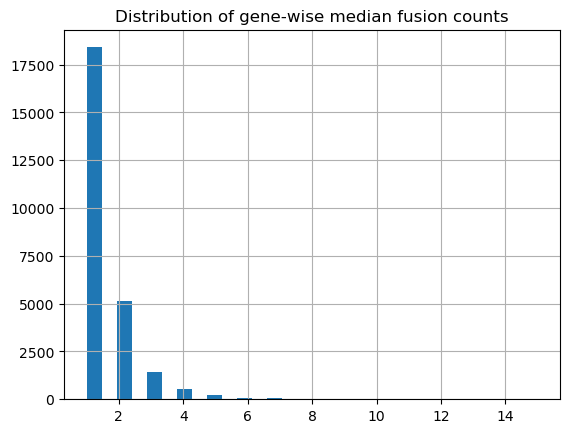

In [205]:
pd.Series(medians).hist(bins=30)
plt.title('Distribution of gene-wise median fusion counts')

In [208]:
pd.Series(medians).value_counts()

1     18404
2      5134
3      1435
4       536
5       199
6        86
7        60
8        32
9        12
10        9
11        6
12        5
13        4
15        1
14        1
Name: count, dtype: int64

Applying >1 filter to all genefusion pairs

In [207]:
def healthy_fusions(fusionfile, threshold=1):
    base = os.path.basename(fusionfile)
    gene = base.split('.')[2]
    df = pd.read_csv(fusionfile, sep='\t', header=None, usecols=[3])
    df.columns = ['gene']
    counts = df['gene'][df['gene'] != gene].value_counts()
    h_fusions = counts[counts > threshold].index.tolist()
    h_fusions = [f'{gene}+{x}' for x in h_fusions]
    return h_fusions
healthy_fusions('/data/jake/genefusion/data/2024_11_01-fusions-1kg/fusions/21.neg.ERG.39751949.40033704.fusions')[0:5]

['ERG+DMD', 'ERG+TM4SF2', 'ERG+LARGE', 'ERG+IL1RAPL1', 'ERG+DSCAM']

In [211]:
outfile_hf= '/data/jake/genefusion/data/healthy_fusions.txt'
def helper(fusionsfile, outfile= outfile_hf):
    with open(outfile, 'a') as f:
        hf = healthy_fusions(fusionsfile, threshold=1)
        for line in hf:
            f.write(line + '\n')
with mp.Pool(processes=cpus) as pool:
    pool.map(helper, fusionfiles)
    

In [215]:
with open(outfile_hf, 'rb') as f:
    n_hf = sum(1 for _ in f)
print(n_hf)
print(n_hf * 10 ** -6, 'M')

48336949
48.336949 M


In [222]:
comb = math.comb(27000,2) * 10 ** -6
comb

364.4865

## Summary

- 3.8M genefusions filtered out by gene-wise 95th percentile
- 34M genefusions filtered out by gene-wise median
- 48M genefusions filtered by median of means (gene fusion count >1)

## Fusion count matrix

- notes:
  - some genes had no fusions
  - some genes have 'gene.2' naming; '.' is the same delimiter I used for file naming.
    - Can still parse from filenames by using forward and reverse splits
      - Example: filename.split('.')[2] -> strand; filename.split('.')[-3] -> start

In [222]:
def filestring2data(string):
    # assumes .giggle extension
    chrm = string.split('.')[0]
    strand = string.split('.')[1]
    gene = string.split('.')[2]
    start = string.split('.')[-3]
    end = string.split('.')[-2]
    # handle rare case where gene name has a period
    if len(string.split('.')) >= 7:
        gene = '.'.join(string.split('.')[2:-3])
    return [chrm, strand, gene, start, end]

In [224]:
# filestring2data('21.neg.ERG.39751949.40033704.giggle')
filestring2data('1.pos.RP3neg426I6.5.28100369.28100552.fusions')

['1', 'pos', 'RP3neg426I6.5', '28100369', '28100552']

In [226]:
print(len(fusionfiles),len(GENES))

26998 26909


In [230]:
def count_gene_var_pairs(fusionfile, GENES=GENES):
    base = os.path.basename(fusionfile)
    gene = str(base.split('.')[2])
    chrm,strand,gene,start,end = filestring2data(base) 
    df = pd.read_csv(fusionfile, sep='\t', header=None, usecols=[3])
    df.columns = [gene]
    counts = df[gene].value_counts()
    counts.name = gene
    return counts
znf = count_gene_var_pairs(fusionfiles[0]).head()
    

In [231]:
fusionfiles[0]

'/data/jake/genefusion/data/2024_11_01-fusions-1kg/fusions/1.neg.ZNF669.247263264.247267674.fusions'

In [232]:
znf.name

'ZNF669'

In [233]:
fusionfiles_not_empty = [f for f in fusionfiles if os.stat(f).st_size > 0]
fusionfiles_empty = [f for f in fusionfiles if os.stat(f).st_size == 0]
fusionfiles_empty[:5]

['/data/jake/genefusion/data/2024_11_01-fusions-1kg/fusions/X.neg.SRPX.38008589.38080696.fusions',
 '/data/jake/genefusion/data/2024_11_01-fusions-1kg/fusions/X.neg.TAF7L.100523241.100548059.fusions',
 '/data/jake/genefusion/data/2024_11_01-fusions-1kg/fusions/Y.neg.FAM197Y8.9185120.9193010.fusions',
 '/data/jake/genefusion/data/2024_11_01-fusions-1kg/fusions/X.pos.NXF2.101470280.101581634.fusions',
 '/data/jake/genefusion/data/2024_11_01-fusions-1kg/fusions/X.neg.NAA10.153194695.153200676.fusions']

In [234]:
empty_genes = [os.path.basename(f).split('.')[2] for f in fusionfiles_empty]
print(len(empty_genes))
empty_genes[:5]

1074


['SRPX', 'TAF7L', 'FAM197Y8', 'NXF2', 'NAA10']

In [235]:
with mp.Pool(processes=cpus) as pool:
    gene_var_pairs = pool.map(count_gene_var_pairs, fusionfiles_not_empty)

In [236]:
print(type(gene_var_pairs[0]))
print(gene_var_pairs[0].shape)
gene_var_pairs[0].head()

<class 'pandas.core.series.Series'>
(1967,)


ZNF669
ARID2       90
ZNF669      67
RPH3AL       9
ARHGAP15     6
ROBO2        6
Name: ZNF669, dtype: int64

In [237]:
names = [x.name for x in gene_var_pairs]
names = pd.Series(names).value_counts()
names

NPIPA7        3
ZNF763        2
UGT2A1        2
MUC3A         2
LCN6          2
             ..
SPDYE3        1
CUEDC2        1
EPHA4         1
MCM3          1
AC110781.3    1
Name: count, Length: 25842, dtype: int64

In [239]:
for n in names.items():
    print(n)
    break

('NPIPA7', 3)


In [240]:
G = pd.Series(GENES)
mask = G.str.contains('RP11neg162G10')
G[mask]


17944    RP11neg162G10.5
dtype: object

In [253]:
n = len(GENES)
A = np.zeros((n,n),dtype=np.int64)
A = pd.DataFrame(A, index=GENES, columns=GENES)
# i = 0
for source in gene_var_pairs:
    for target, count in source.items():
        A.loc[source.name, target] += count
    # i += 1
    # if i >=10:
    #     break
# mask = A.index.str.contains('RP3neg508I15')
# A[mask]

In [254]:
A.to_csv('/data/jake/genefusion/data/1kg-gene_var_pairs.csv',sep='\t')

In [252]:
A.loc['CCL3', 'CCL3']

np.int64(37)

In [255]:
A.head()

,7SK,A1BG,A1BGnegAS1,A1CF,A2M,A2ML1,A2ML1negAS1,A2ML1negAS2,A2MnegAS1,A3GALT2,...,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,hsanegmirneg1199,hsanegmirneg150,hsanegmirneg335,hsanegmirneg490
7SK,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1BG,0,194,162,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1BGnegAS1,0,146,221,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1CF,0,1,1,1459,2,1,1,0,0,0,...,0,0,0,0,4,0,0,0,0,0
A2M,0,0,0,0,860,0,0,0,1,0,...,0,0,0,0,2,0,0,0,0,0


In [256]:
# numpy file format might reduce read time
B = pd.read_csv('/data/jake/genefusion/data/1kg-gene_var_pairs.csv', sep='\t', index_col=0)
B.head()

,7SK,A1BG,A1BGnegAS1,A1CF,A2M,A2ML1,A2ML1negAS1,A2ML1negAS2,A2MnegAS1,A3GALT2,...,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,hsanegmirneg1199,hsanegmirneg150,hsanegmirneg335,hsanegmirneg490
7SK,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1BG,0,194,162,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1BGnegAS1,0,146,221,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1CF,0,1,1,1459,2,1,1,0,0,0,...,0,0,0,0,4,0,0,0,0,0
A2M,0,0,0,0,860,0,0,0,1,0,...,0,0,0,0,2,0,0,0,0,0


In [251]:
indices = list(zip(*((A > 0).values).nonzero()))
for (i,j) in indices:
    print(A.index[i], A.columns[j])

CCL3 ABCA5
CCL3 AC008132.13
CCL3 AC011043.1
CCL3 AC069363.1
CCL3 AC131056.3
CCL3 ADORA2AnegAS1
CCL3 ADRBK2
CCL3 AF165138.7
CCL3 AP001596.6
CCL3 AP001597.1
CCL3 BAIAP2
CCL3 BIK
CCL3 BLVRB
CCL3 C21orf49
CCL3 C21orf58
CCL3 C22orf34
CCL3 C22orf39
CCL3 CACNG5
CCL3 CCDC102B
CCL3 CCDC178
CCL3 CCDC68
CCL3 CCL3
CCL3 CCL3L1
CCL3 CCL3L3
CCL3 CD70
CCL3 CDH19
CCL3 CDH2
CCL3 CDH4
CCL3 CEP76
CCL3 COL20A1
CCL3 COLEC12
CCL3 COMMD7
CCL3 CTDneg3187F8.14
CCL3 DHX8
CCL3 DSCR4
CCL3 FAM197Y2
CCL3 FAM65C
CCL3 FBN3
CCL3 FBXL20
CCL3 FRMPD4
CCL3 HIRA
CCL3 ICOSLG
CCL3 KCNG2
CCL3 KLHL26
CCL3 LDOC1L
CCL3 LL22NC03neg63E9.3
CCL3 LOXHD1
CCL3 MTnegCYB
CCL3 NCAM2
CCL3 NDC80
CCL3 NHS
CCL3 NLGN4X
CCL3 NWD1
CCL3 P2RY8
CCL3 PCSK2
CCL3 PDXK
CCL3 PI4KA
CCL3 PIWIL3
CCL3 PSMG2
CCL3 PTBP1
CCL3 RALGAPB
CCL3 RP11neg449L23.3
CCL3 RP11neg861L17.3
CCL3 RP3neg508I15.18
CCL3 RP3neg508I15.19
CCL3 RP4neg678D15.1
CCL3 SDK2
CCL3 SLC17A7
CCL3 SLC24A3
CCL3 SLC44A2
CCL3 STARD3
CCL3 STAT3
CCL3 SUN2
CCL3 TBC1D3C
CCL3 TBC1D3H
CCL3 TBCD
CCL3 TEX1

In [82]:
# sort fusionfiles by gene name
df_fusionfiles = pd.DataFrame(fusionfiles, columns=['file'])
df_fusionfiles['gene_loc'] = df_fusionfiles['file'].apply(lambda x: filestring2data(os.path.basename(x)))
# reorder
df_fusionfiles['gene_loc'] = df_fusionfiles['gene_loc'].apply(lambda x: f'{x[2]}_{x[0]}_{x[3]}_{x[4]}')
df_fusionfiles_sort = df_fusionfiles.sort_values('gene_loc').reset_index(drop=True)
df_fusionfiles_sort

,file,gene_loc
0,/data/jake/genefusion/data/2024_11_01-fusions-...,7SK_8_144624280_144624570
1,/data/jake/genefusion/data/2024_11_01-fusions-...,A1BG_19_58856544_58864865
2,/data/jake/genefusion/data/2024_11_01-fusions-...,A1BGnegAS1_19_58859117_58866549
3,/data/jake/genefusion/data/2024_11_01-fusions-...,A1CF_10_52559169_52645435
4,/data/jake/genefusion/data/2024_11_01-fusions-...,A2ML1_12_8975068_9039597
...,...,...
25919,/data/jake/genefusion/data/2024_11_01-fusions-...,ZZZ3_1_78028101_78149104
25920,/data/jake/genefusion/data/2024_11_01-fusions-...,hsanegmirneg1199_19_14183348_14185874
25921,/data/jake/genefusion/data/2024_11_01-fusions-...,hsanegmirneg150_19_50003781_50004614
25922,/data/jake/genefusion/data/2024_11_01-fusions-...,hsanegmirneg335_7_130135635_130138268


In [19]:
for i, file in enumerate(df_fusionfiles_sort['file'].values):
    print(file)
    base_i = os.path.basename(file)
    gene_i = base_i.split('.')[2]
    fusions = pd.read_csv(file, sep='\t', header=None, usecols=[3])
    fusions.columns = ['gene']
    fusions = fusions['gene'].value_counts().sort_values(ascending=False)
    for gene in GENES:
        if not gene in fusions.index.tolist():
            # fill absent genes with 0
            fusions.loc[gene] = 0
    break
fusions

/data/jake/genefusion/data/2024_11_01-fusions-1kg/fusions/8.pos.7SK.144624280.144624570.fusions


gene
RP11neg661A12.5    6
MACROD2            2
MRC1L1             1
CCNY               1
AGAP6              1
                  ..
DAZ3               0
DAZ4               0
BPY2C              0
CDY1               0
AC007965.1         0
Name: count, Length: 26909, dtype: int64

In [27]:
# ex_fusion_list = fusions.index.tolist()
# ex_fusion_list.sort()
# i=0
# for g in GENES:
#     if g not in ex_fusion_list:
#         print(g)
#         i+=1
print(len(GENES))
len(ex_fusion_list)

26998


26909

In [269]:
# proof of concept
n = len(fusionfiles)
A = np.zeros((n,n),dtype=np.int32)
A = pd.DataFrame(A, index=genes, columns=genes)
for i, file in enumerate(df_fusionfiles_sort['file'].values):
    print(i, file)
    base_i = os.path.basename(file)
    gene_i = base_i.split('.')[2]
    fusions = pd.read_csv(file, sep='\t', header=None, usecols=[3])
    fusions.columns = ['gene']
    fusions = fusions['gene'].value_counts().sort_index()
    print(fusions)
    for gene_j, count in fusions.items():
        print(gene_i, gene_j, count)
        A.loc[gene_i, gene_j] = count
        break
    break
A
    

0 /data/jake/genefusion/data/2024_11_01-fusions-1kg/fusions/8.pos.7SK.144624280.144624570.fusions
gene
AC100830.3    1
ADK           1
AGAP6         1
ANAPC16       1
ANKS1B        1
             ..
TEX10         1
TRPM3         1
TSHZ2         1
UBASH3B       1
URI1          1
Name: count, Length: 83, dtype: int64
7SK AC100830.3 1


,7SK,A1BG,A1BGnegAS1,A1CF,A2M,A2ML1,A2ML1negAS1,A2ML1negAS2,A2MnegAS1,A3GALT2,...,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,hsanegmirneg1199,hsanegmirneg150,hsanegmirneg335,hsanegmirneg490,AC100830.3
7SK,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
A1BG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
A1BGnegAS1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
A1CF,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
A2M,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZZZ3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
hsanegmirneg1199,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
hsanegmirneg150,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
hsanegmirneg335,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN


In [251]:
A.loc['ZNF669', 'ARID2']

np.int32(90)

In [259]:
# sort fusionfiles by gene name
df_fusionfiles = pd.DataFrame(fusionfiles, columns=['file'])
df_fusionfiles['gene'] = df_fusionfiles['file'].apply(lambda x: os.path.basename(x).split('.')[2])
df_fusionfiles_sort = df_fusionfiles.sort_values('gene')
df_fusionfiles_sort

,file,gene
15301,/data/jake/genefusion/data/2024_11_01-fusions-...,7SK
8697,/data/jake/genefusion/data/2024_11_01-fusions-...,A1BG
8611,/data/jake/genefusion/data/2024_11_01-fusions-...,A1BGnegAS1
21210,/data/jake/genefusion/data/2024_11_01-fusions-...,A1CF
44,/data/jake/genefusion/data/2024_11_01-fusions-...,A2M
...,...,...
19559,/data/jake/genefusion/data/2024_11_01-fusions-...,ZZZ3
2701,/data/jake/genefusion/data/2024_11_01-fusions-...,hsanegmirneg1199
18472,/data/jake/genefusion/data/2024_11_01-fusions-...,hsanegmirneg150
20652,/data/jake/genefusion/data/2024_11_01-fusions-...,hsanegmirneg335


In [264]:
df_fusionfiles_sort['file'].values

array(['/data/jake/genefusion/data/2024_11_01-fusions-1kg/fusions/8.pos.7SK.144624280.144624570.fusions',
       '/data/jake/genefusion/data/2024_11_01-fusions-1kg/fusions/19.neg.A1BG.58856544.58864865.fusions',
       '/data/jake/genefusion/data/2024_11_01-fusions-1kg/fusions/19.pos.A1BGnegAS1.58859117.58866549.fusions',
       ...,
       '/data/jake/genefusion/data/2024_11_01-fusions-1kg/fusions/19.pos.hsanegmirneg150.50003781.50004614.fusions',
       '/data/jake/genefusion/data/2024_11_01-fusions-1kg/fusions/7.neg.hsanegmirneg335.130135635.130138268.fusions',
       '/data/jake/genefusion/data/2024_11_01-fusions-1kg/fusions/7.neg.hsanegmirneg490.136370306.136866854.fusions'],
      dtype=object)

In [253]:
# very slow; do parallel gene-wise, then (h/v)stack concatenate
# use npz format to store
n = len(genes)
A = np.zeros((n,n),dtype=np.int32)
for i, file in enumerate(df_fusionfiles_sort['file'].values):
    base_i = os.path.basename(file)
    gene_i = base_i.split('.')[2]
    fusions = pd.read_csv(file, sep='\t', header=None, usecols=[3])
    fusions.columns = ['gene']
    fusions = fusions['gene'].value_counts()
    for gene_j, count in fusions.items():
        A[i, gene_j] = count
A_f = fusion_matrix(fusionfiles, genes)
A_f.head()

/tmp/ipykernel_1957274/2124268439.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  A.loc[gene_i, gene_j] = count
/tmp/ipykernel_1957274/2124268439.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  A.loc[gene_i, gene_j] = count
/tmp/ipykernel_1957274/2124268439.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

KeyboardInterrupt: 

In [278]:
# linear fill genefusion matrix
for i, file in enumerate(df_fusionfiles_sort['file'].values):
    base_i = os.path.basename(file)
    gene_i = base_i.split('.')[2]
    fusions = pd.read_csv(file, sep='\t', header=None, usecols=[3])
    fusions.columns = ['gene']
    fusions = fusions['gene'].value_counts().sort_values(ascending=False)
    # add zeros for no absent gene fusions
    for gene in genes:
        if gene not in fusions.index:
            fusions[gene] = 0
    fusions.index
    print(gene_i,file)
    print(fusions)
    print(fusions.shape, print(len(genes)))
    break

7SK /data/jake/genefusion/data/2024_11_01-fusions-1kg/fusions/8.pos.7SK.144624280.144624570.fusions
gene
RP11neg661A12.5     6
MACROD2             2
MRC1L1              1
CCNY                1
AGAP6               1
                   ..
ZZZ3                0
hsanegmirneg1199    0
hsanegmirneg150     0
hsanegmirneg335     0
hsanegmirneg490     0
Name: count, Length: 24361, dtype: int64
25924
(24361,) None


In [276]:
genes

['7SK',
 'A1BG',
 'A1BGnegAS1',
 'A1CF',
 'A2M',
 'A2ML1',
 'A2ML1negAS1',
 'A2ML1negAS2',
 'A2MnegAS1',
 'A3GALT2',
 'A4GALT',
 'A4GNT',
 'AAAS',
 'AACS',
 'AADAC',
 'AADACL2',
 'AADACL3',
 'AADACL4',
 'AADAT',
 'AAED1',
 'AAGAB',
 'AAK1',
 'AAMDC',
 'AAMP',
 'AANAT',
 'AAR2',
 'AARD',
 'AARS',
 'AARS2',
 'AARSD1',
 'AASDH',
 'AASDHPPT',
 'AASS',
 'AATF',
 'AATK',
 'AATKnegAS1',
 'ABAT',
 'ABCA1',
 'ABCA10',
 'ABCA12',
 'ABCA13',
 'ABCA2',
 'ABCA3',
 'ABCA4',
 'ABCA5',
 'ABCA6',
 'ABCA7',
 'ABCA8',
 'ABCA9',
 'ABCA9negAS1',
 'ABCB1',
 'ABCB10',
 'ABCB11',
 'ABCB4',
 'ABCB5',
 'ABCB6',
 'ABCB8',
 'ABCB9',
 'ABCC1',
 'ABCC10',
 'ABCC11',
 'ABCC12',
 'ABCC2',
 'ABCC3',
 'ABCC4',
 'ABCC5',
 'ABCC5negAS1',
 'ABCC6',
 'ABCC8',
 'ABCC9',
 'ABCD2',
 'ABCD3',
 'ABCD4',
 'ABCE1',
 'ABCF1',
 'ABCF2',
 'ABCF3',
 'ABCG1',
 'ABCG2',
 'ABCG4',
 'ABCG5',
 'ABCG8',
 'ABHD1',
 'ABHD10',
 'ABHD11',
 'ABHD12',
 'ABHD12B',
 'ABHD13',
 'ABHD14A',
 'ABHD14AnegACY1',
 'ABHD14B',
 'ABHD15',
 'ABHD16A',
 'ABHD

In [ ]:
A_f.to_csv('/data/jake/genefusion/data/1kg_fusion_matrix.csv',sep='\t',compression='gzip')

## Test


In [226]:
matrix = np.random.randint(low=0, high=100, size=(30000, 30000), dtype=np.int32)
matrix

array([[36, 81, 42, ..., 81,  1, 77],
       [ 9, 92, 43, ..., 82, 25, 33],
       [74, 26,  9, ...,  4,  2, 26],
       ...,
       [ 8, 85, 14, ..., 37,  0, 21],
       [33, 80,  9, ..., 50, 12, 57],
       [45, 71, 54, ..., 43, 34, 35]], dtype=int32)

In [229]:
sys.getsizeof(matrix) * 10 ** -9

3.600000128